# Лабораторная работа №3. Проведение исследований с решающим деревом

Импорт библиотек и настройка окружения\
Решающее дерево для классификации/регрессии: загрузка, метрики, визуализации

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    precision_recall_curve,
    precision_score,
    r2_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree

pd.set_option("display.max_columns", 120)
RANDOM_STATE = 42
sns.set_theme(style="whitegrid")

Загрузка датасетов\
Используем COVID (классификация) и страховые выплаты (регрессия)

In [2]:
covid_path = Path("../datasets/covid.csv")
insurance_path = Path("../datasets/insurance.csv")

df_covid_raw = pd.read_csv(covid_path)
df_insurance_raw = pd.read_csv(insurance_path)

Вспомогательные функции для метрик, таблиц и графиков\
Унифицированный расчет метрик, таблицы и визуализации ROC/PR, ошибок и важности

In [3]:
def classification_report_dict(y_true, y_pred, y_proba=None):
    scores = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
    }
    if y_proba is not None:
        try:
            scores["roc_auc"] = roc_auc_score(y_true, y_proba)
        except ValueError:
            scores["roc_auc"] = np.nan
    return scores


def regression_report_dict(y_true, y_pred):
    return {
        "mae": mean_absolute_error(y_true, y_pred),
        "rmse": np.sqrt(mean_squared_error(y_true, y_pred)),
        "r2": r2_score(y_true, y_pred),
    }


def show_results_table(results, title):
    print(f"\n{title}")
    display_df = pd.DataFrame(results).T
    display_df = display_df.round(4)
    print(display_df)


def plot_confusion(cm, title):
    plt.figure(figsize=(4.5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_roc_pr(y_true, proba_dict):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    for label, proba in proba_dict.items():
        fpr, tpr, _ = roc_curve(y_true, proba)
        plt.plot(fpr, tpr, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC-кривые")
    plt.legend()

    plt.subplot(1, 2, 2)
    for label, proba in proba_dict.items():
        precision, recall, _ = precision_recall_curve(y_true, proba)
        plt.plot(recall, precision, label=label)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_residuals(true, preds_dict):
    plt.figure(figsize=(8, 4))
    for label, pred in preds_dict.items():
        residuals = true - pred
        sns.kdeplot(residuals, label=label, fill=True, alpha=0.3)
    plt.title("Плотности остатков моделей")
    plt.xlabel("Ошибка (true - pred)")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_predictions(true, preds_dict):
    plt.figure(figsize=(12, 5))
    for i, (label, pred) in enumerate(preds_dict.items()):
        plt.subplot(1, len(preds_dict), i + 1)
        sns.scatterplot(x=true, y=pred, alpha=0.6)
        m, M = true.min(), true.max()
        plt.plot([m, M], [m, M], "r--")
        plt.title(f"{label}: true vs pred")
        plt.xlabel("true")
        plt.ylabel("pred")
    plt.tight_layout()
    plt.show()


def plot_feature_importance(importances, feature_names, title, top_n=15):
    imp_df = pd.DataFrame({"feature": feature_names, "importance": importances})
    imp_df = imp_df.reindex(imp_df.importance.abs().sort_values(ascending=False).index)
    imp_df = imp_df.head(top_n)
    plt.figure(figsize=(8, 5))
    sns.barplot(data=imp_df, x="importance", y="feature")
    plt.title(title)
    plt.tight_layout()
    plt.show()

Предобработка COVID под задачу классификации\
Целевая переменная: факт смерти, обработка кодов пропусков и доп. признак COVID_POSITIVE

In [4]:
covid_df = df_covid_raw.copy()
covid_df["died"] = (covid_df["DATE_DIED"] != "9999-99-99").astype(int)
covid_df["COVID_POSITIVE"] = (covid_df["CLASIFFICATION_FINAL"] <= 3).astype(int)
covid_df = covid_df.drop(columns=["DATE_DIED"])

covid_df = covid_df.replace({97: np.nan, 98: np.nan, 99: np.nan})
feature_cols_covid = [c for c in covid_df.columns if c != "died"]

covid_sample = covid_df.sample(n=80000, random_state=RANDOM_STATE)

COVID EDA: распределения и ключевые зависимости\
Базовые графики: таргет, возраст, корреляции, коморбидности

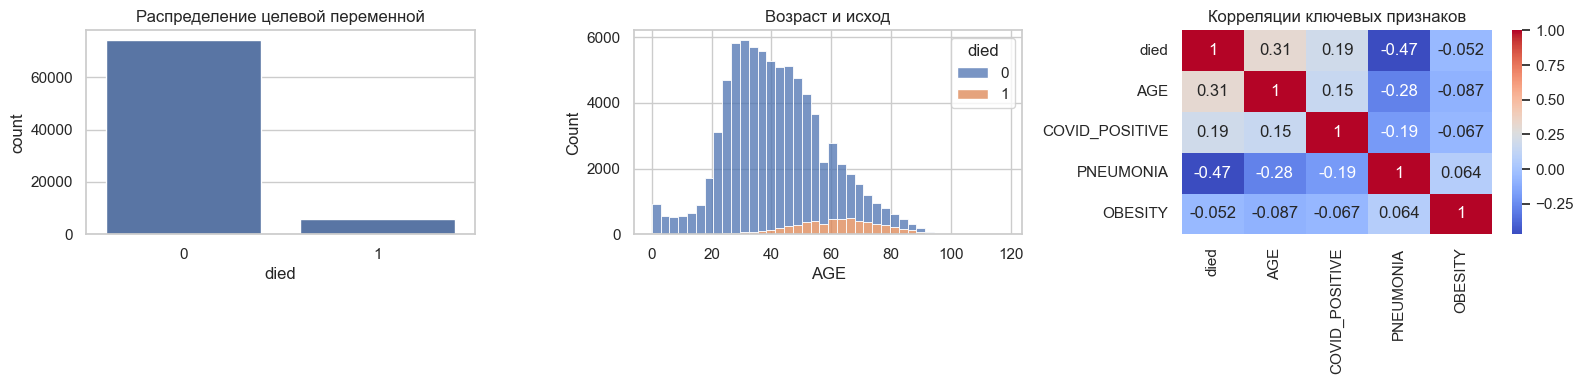

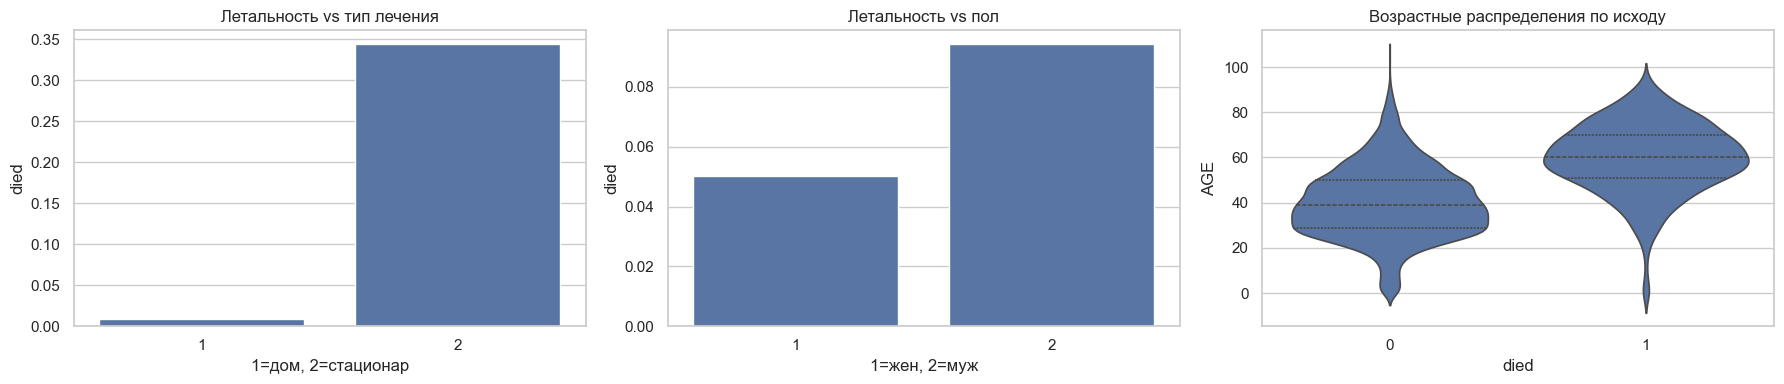

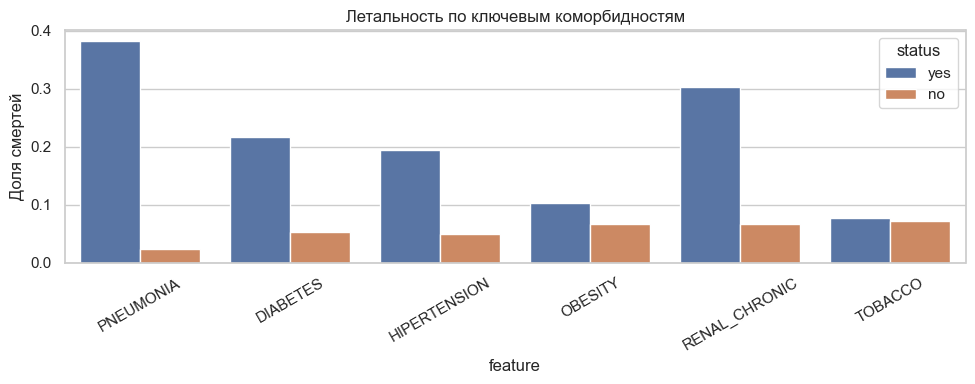

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
sns.countplot(data=covid_sample, x="died", ax=axes[0])
axes[0].set_title("Распределение целевой переменной")

sns.histplot(
    data=covid_sample,
    x="AGE",
    hue="died",
    multiple="stack",
    bins=40,
    ax=axes[1],
)
axes[1].set_title("Возраст и исход")

corr_subset = covid_sample[["died", "AGE", "COVID_POSITIVE", "PNEUMONIA", "OBESITY"]]
sns.heatmap(corr_subset.corr(), annot=True, cmap="coolwarm", ax=axes[2])
axes[2].set_title("Корреляции ключевых признаков")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

sns.barplot(
    data=covid_sample,
    x="PATIENT_TYPE",
    y="died",
    estimator=np.mean,
    errorbar=None,
    ax=axes[0],
)
axes[0].set_title("Летальность vs тип лечения")
axes[0].set_xlabel("1=дом, 2=стационар")

sns.barplot(
    data=covid_sample,
    x="SEX",
    y="died",
    estimator=np.mean,
    errorbar=None,
    ax=axes[1],
)
axes[1].set_title("Летальность vs пол")
axes[1].set_xlabel("1=жен, 2=муж")

sns.violinplot(
    data=covid_sample.sample(8000, random_state=RANDOM_STATE),
    x="died",
    y="AGE",
    inner="quart",
    ax=axes[2],
)
axes[2].set_title("Возрастные распределения по исходу")
plt.tight_layout()
plt.show()

risk_cols = ["PNEUMONIA", "DIABETES", "HIPERTENSION", "OBESITY", "RENAL_CHRONIC", "TOBACCO"]

risk_records = []
for col in risk_cols:
    yes_mean = covid_sample.loc[covid_sample[col] == 1, "died"].mean()
    no_mean = covid_sample.loc[covid_sample[col] == 2, "died"].mean()
    risk_records.append({"feature": col, "status": "yes", "mortality": yes_mean})
    risk_records.append({"feature": col, "status": "no", "mortality": no_mean})

risk_df = pd.DataFrame(risk_records)
plt.figure(figsize=(10, 4))
sns.barplot(data=risk_df, x="feature", y="mortality", hue="status")
plt.xticks(rotation=30)
plt.title("Летальность по ключевым коморбидностям")
plt.ylabel("Доля смертей")
plt.tight_layout()
plt.show()

Бейзлайн дерева решений (классификация)\
Пайплайн: импутация, стандартизация, DecisionTreeClassifier без тюнинга

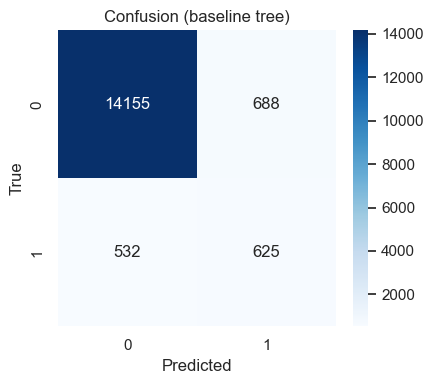

In [6]:
X_covid = covid_sample[feature_cols_covid]
y_covid = covid_sample["died"]

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_covid, y_covid, test_size=0.2, stratify=y_covid, random_state=RANDOM_STATE
)

cls_baseline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("scaler", StandardScaler()),
        (
            "model",
            DecisionTreeClassifier(
                max_depth=None,
                random_state=RANDOM_STATE,
                class_weight="balanced",
            ),
        ),
    ]
)

cls_baseline.fit(X_train_c, y_train_c)
base_pred = cls_baseline.predict(X_test_c)
base_proba = cls_baseline.predict_proba(X_test_c)[:, 1]

results_cls = {}
results_cls["baseline_tree"] = classification_report_dict(y_test_c, base_pred, base_proba)

plot_confusion(confusion_matrix(y_test_c, base_pred), "Confusion (baseline tree)")

Тюнинг дерева (классификация)\
GridSearchCV по глубине, числу листьев и min_samples_leaf

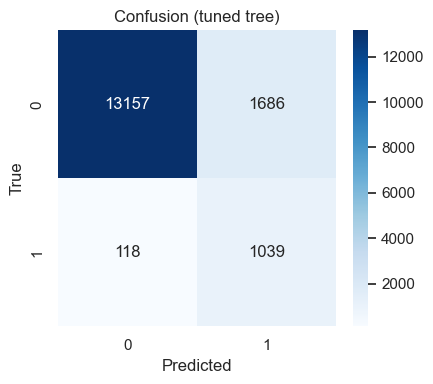

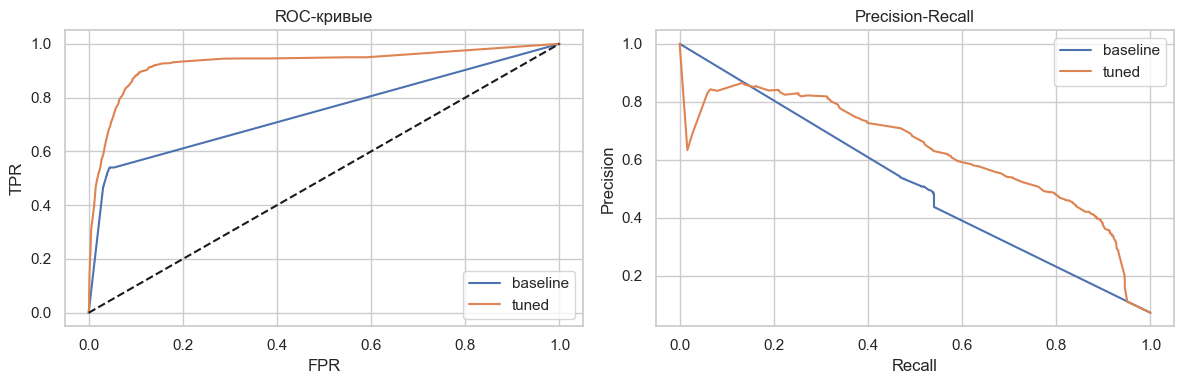

In [7]:
param_grid_cls = {
    "model__max_depth": [6, 10, 16, None],
    "model__min_samples_leaf": [1, 5, 15],
    "model__min_samples_split": [2, 10, 20],
    "model__criterion": ["gini", "entropy"],
}

cv_cls = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)

cls_search = GridSearchCV(
    estimator=cls_baseline,
    param_grid=param_grid_cls,
    scoring="f1",
    cv=cv_cls,
    n_jobs=-1,
)
cls_search.fit(X_train_c, y_train_c)

best_tree_cls = cls_search.best_estimator_
best_pred = best_tree_cls.predict(X_test_c)
best_proba = best_tree_cls.predict_proba(X_test_c)[:, 1]

results_cls["tuned_tree"] = classification_report_dict(y_test_c, best_pred, best_proba)

plot_confusion(confusion_matrix(y_test_c, best_pred), "Confusion (tuned tree)")
plot_roc_pr(y_test_c, {"baseline": base_proba, "tuned": best_proba})

Важность признаков для лучшего дерева (классификация)\
Показываем топ-важности для интерпретации модели

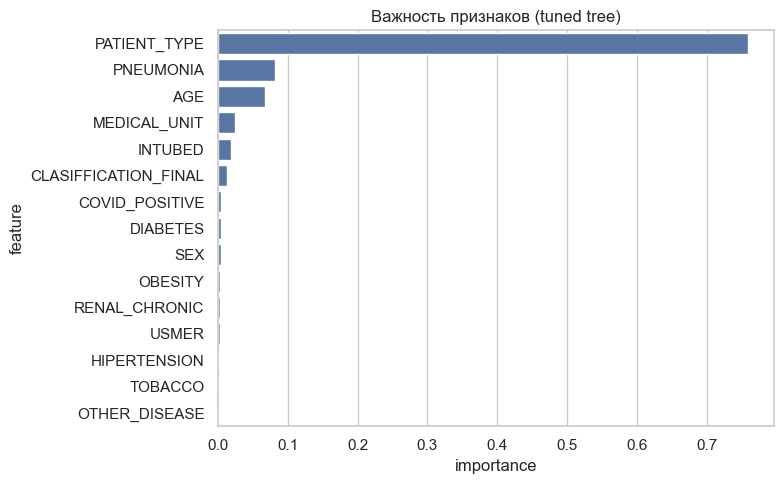

In [8]:
feature_importances_cls = best_tree_cls.named_steps["model"].feature_importances_
plot_feature_importance(feature_importances_cls, feature_cols_covid, "Важность признаков (tuned tree)")

Ручная имплементация дерева (простое жадное дерево)\
Упрощенная версия CART для числовых признаков с gini / mse критерием

In [9]:
class SimpleDecisionTreeClassifier:
    def __init__(self, max_depth=5, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf

    def _gini(self, y):
        if len(y) == 0:
            return 0.0
        _, counts = np.unique(y, return_counts=True)
        p = counts / len(y)
        return 1.0 - np.sum(p ** 2)

    def _best_split(self, X, y):
        best_feat, best_thr, best_gain = None, None, -np.inf
        current_impurity = self._gini(y)
        n_samples, n_features = X.shape
        for feat in range(n_features):
            thresholds = np.unique(X[:, feat])
            for thr in thresholds:
                left_mask = X[:, feat] <= thr
                right_mask = ~left_mask
                if left_mask.sum() < self.min_samples_leaf or right_mask.sum() < self.min_samples_leaf:
                    continue
                g_left = self._gini(y[left_mask])
                g_right = self._gini(y[right_mask])
                gain = current_impurity - (
                    (left_mask.sum() / n_samples) * g_left
                    + (right_mask.sum() / n_samples) * g_right
                )
                if gain > best_gain:
                    best_gain = gain
                    best_feat = feat
                    best_thr = thr
        return best_feat, best_thr, best_gain

    def _build(self, X, y, depth):
        node = {}
        # листья или отсутствие улучшения
        if depth >= self.max_depth or len(np.unique(y)) == 1:
            node["type"] = "leaf"
            vals, counts = np.unique(y, return_counts=True)
            node["class"] = vals[np.argmax(counts)]
            # распределение вероятностей по классам для predict_proba
            proba = np.zeros(len(self.classes_))
            for v, c in zip(vals, counts):
                idx = np.where(self.classes_ == v)[0][0]
                proba[idx] = c / counts.sum()
            node["proba"] = proba
            return node

        feat, thr, gain = self._best_split(X, y)
        if feat is None or gain <= 0:
            node["type"] = "leaf"
            vals, counts = np.unique(y, return_counts=True)
            node["class"] = vals[np.argmax(counts)]
            proba = np.zeros(len(self.classes_))
            for v, c in zip(vals, counts):
                idx = np.where(self.classes_ == v)[0][0]
                proba[idx] = c / counts.sum()
            node["proba"] = proba
            return node

        node["type"] = "node"
        node["feat"] = feat
        node["thr"] = thr
        left_mask = X[:, feat] <= thr
        right_mask = ~left_mask
        node["left"] = self._build(X[left_mask], y[left_mask], depth + 1)
        node["right"] = self._build(X[right_mask], y[right_mask], depth + 1)
        return node

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y)
        self.classes_ = np.unique(y)
        self.n_features_in_ = X.shape[1]
        self.tree_ = self._build(X, y, depth=0)
        return self

    def _predict_row(self, row, node):
        if node["type"] == "leaf":
            return node["class"]
        if row[node["feat"]] <= node["thr"]:
            return self._predict_row(row, node["left"])
        return self._predict_row(row, node["right"])

    def _predict_row_proba(self, row, node):
        if node["type"] == "leaf":
            return node["proba"]
        if row[node["feat"]] <= node["thr"]:
            return self._predict_row_proba(row, node["left"])
        return self._predict_row_proba(row, node["right"])

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        return np.array([self._predict_row(row, self.tree_) for row in X])

    def predict_proba(self, X):
        X = np.asarray(X, dtype=float)
        return np.vstack([self._predict_row_proba(row, self.tree_) for row in X])


class SimpleDecisionTreeRegressor:
    def __init__(self, max_depth=5, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf

    def _mse(self, y):
        if len(y) == 0:
            return 0.0
        return np.var(y)

    def _best_split(self, X, y):
        best_feat, best_thr, best_gain = None, None, -np.inf
        current_mse = self._mse(y)
        n_samples, n_features = X.shape
        for feat in range(n_features):
            thresholds = np.unique(X[:, feat])
            for thr in thresholds:
                left_mask = X[:, feat] <= thr
                right_mask = ~left_mask
                if left_mask.sum() < self.min_samples_leaf or right_mask.sum() < self.min_samples_leaf:
                    continue
                mse_left = self._mse(y[left_mask])
                mse_right = self._mse(y[right_mask])
                gain = current_mse - (
                    (left_mask.sum() / n_samples) * mse_left
                    + (right_mask.sum() / n_samples) * mse_right
                )
                if gain > best_gain:
                    best_gain = gain
                    best_feat = feat
                    best_thr = thr
        return best_feat, best_thr, best_gain

    def _build(self, X, y, depth):
        node = {}
        if depth >= self.max_depth:
            node["type"] = "leaf"
            node["value"] = y.mean()
            return node

        feat, thr, gain = self._best_split(X, y)
        if feat is None or gain <= 0:
            node["type"] = "leaf"
            node["value"] = y.mean()
            return node

        node["type"] = "node"
        node["feat"] = feat
        node["thr"] = thr
        left_mask = X[:, feat] <= thr
        right_mask = ~left_mask
        node["left"] = self._build(X[left_mask], y[left_mask], depth + 1)
        node["right"] = self._build(X[right_mask], y[right_mask], depth + 1)
        return node

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)
        self.n_features_in_ = X.shape[1]
        self.tree_ = self._build(X, y, depth=0)
        return self

    def _predict_row(self, row, node):
        if node["type"] == "leaf":
            return node["value"]
        if row[node["feat"]] <= node["thr"]:
            return self._predict_row(row, node["left"])
        return self._predict_row(row, node["right"])

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        return np.array([self._predict_row(row, self.tree_) for row in X])

Оценка кастомного дерева (классификация) на компактной выборке\
Сжимаем выборку для скорости, сравниваем метрики с sklearn

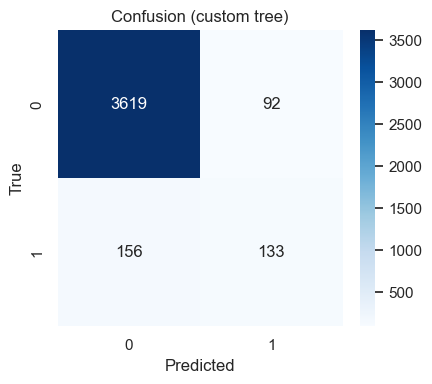


Метрики классификации (деревья)
               accuracy  precision  recall      f1  roc_auc
baseline_tree    0.9238     0.4760  0.5402  0.5061   0.7478
tuned_tree       0.8872     0.3813  0.8980  0.5353   0.9266
custom_tree      0.9380     0.5911  0.4602  0.5175   0.9022


In [10]:
X_c_small, _, y_c_small, _ = train_test_split(
    X_covid,
    y_covid,
    train_size=20000,
    stratify=y_covid,
    random_state=RANDOM_STATE,
)

X_train_cs, X_test_cs, y_train_cs, y_test_cs = train_test_split(
    X_c_small,
    y_c_small,
    test_size=0.2,
    stratify=y_c_small,
    random_state=RANDOM_STATE,
)

custom_tree_cls = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("scaler", StandardScaler()),
        ("model", SimpleDecisionTreeClassifier(max_depth=8, min_samples_leaf=5)),
    ]
)

custom_tree_cls.fit(X_train_cs, y_train_cs)
custom_pred = custom_tree_cls.predict(X_test_cs)
custom_proba = custom_tree_cls.predict_proba(X_test_cs)[:, 1]

results_cls["custom_tree"] = classification_report_dict(
    y_test_cs, custom_pred, custom_proba
)
plot_confusion(confusion_matrix(y_test_cs, custom_pred), "Confusion (custom tree)")

show_results_table(results_cls, "Метрики классификации (деревья)")

Предобработка страховых данных под регрессию\
ColumnTransformer для числовых/категориальных, таргет = charges

In [11]:
insurance_df = df_insurance_raw.copy()
reg_target = insurance_df["charges"]
reg_features = insurance_df.drop(columns=["charges"])

num_cols = ["age", "bmi", "children"]
cat_cols = ["sex", "smoker", "region"]

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False)),
    ]
)

reg_preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

EDA по страховым данным\
Распределения, влияние курения/региона, линейный тренд по возрасту

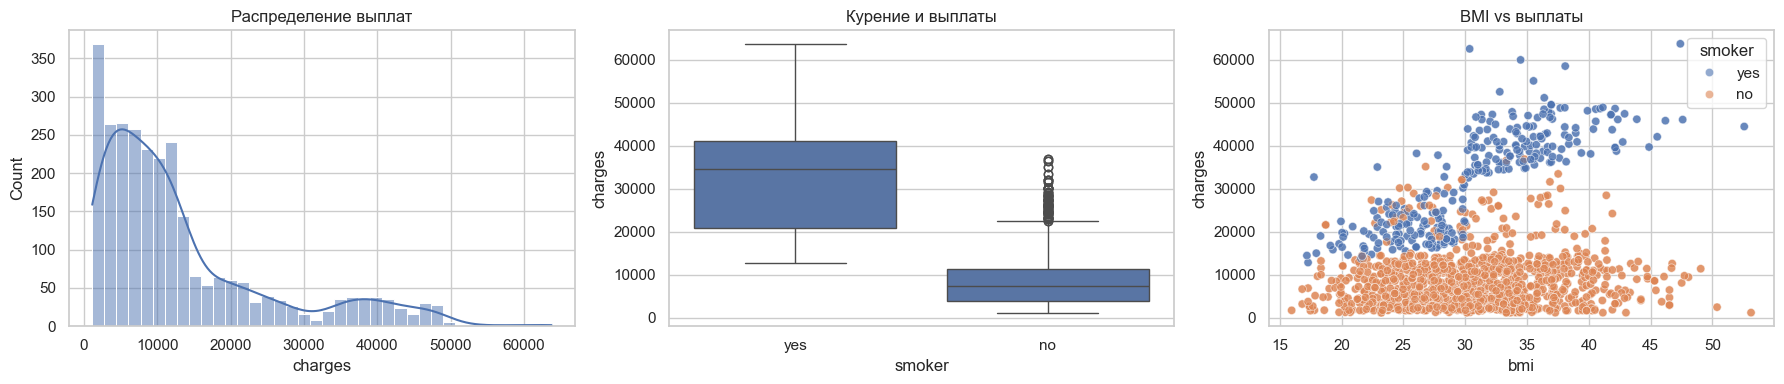

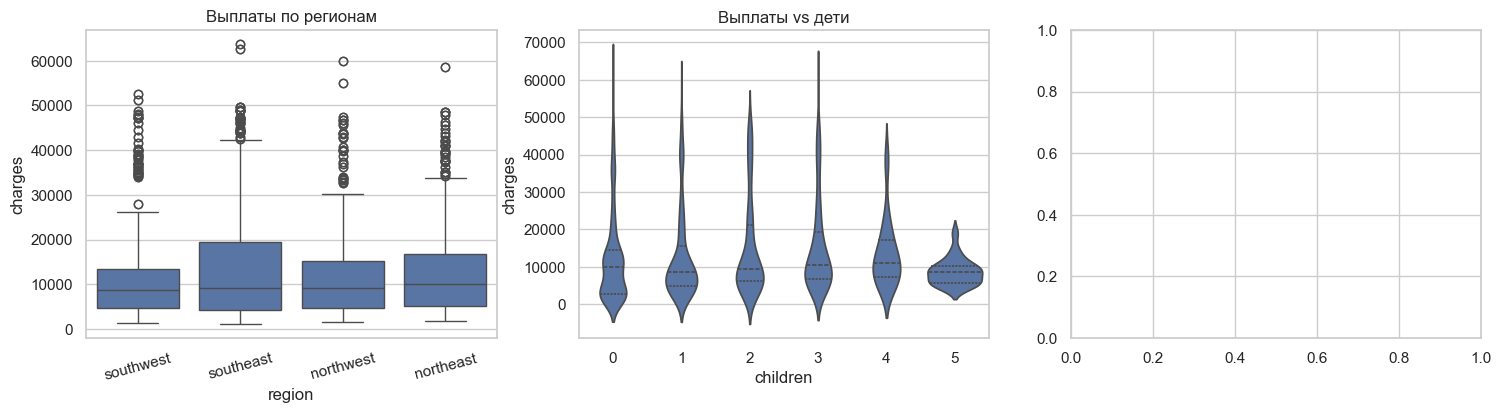

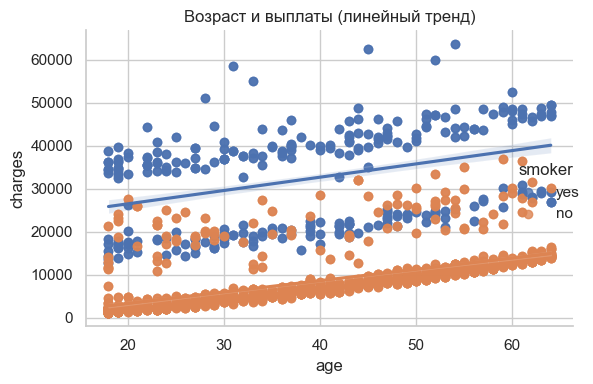

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
sns.histplot(reg_target, kde=True, ax=axes[0])
axes[0].set_title("Распределение выплат")

sns.boxplot(data=insurance_df, x="smoker", y="charges", ax=axes[1])
axes[1].set_title("Курение и выплаты")

sns.scatterplot(
    data=insurance_df,
    x="bmi",
    y="charges",
    hue="smoker",
    alpha=0.6,
    ax=axes[2],
)
axes[2].set_title("BMI vs выплаты")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

sns.boxplot(data=insurance_df, x="region", y="charges", ax=axes[0])
axes[0].set_title("Выплаты по регионам")
axes[0].tick_params(axis="x", rotation=15)

sns.violinplot(data=insurance_df, x="children", y="charges", inner="quart", ax=axes[1])
axes[1].set_title("Выплаты vs дети")

sns.lmplot(data=insurance_df, x="age", y="charges", hue="smoker", height=4, aspect=1.3)
plt.title("Возраст и выплаты (линейный тренд)")
plt.tight_layout()
plt.show()

Бейзлайн дерева (регрессия)\
Пайплайн: препроцессинг + DecisionTreeRegressor без тюнинга

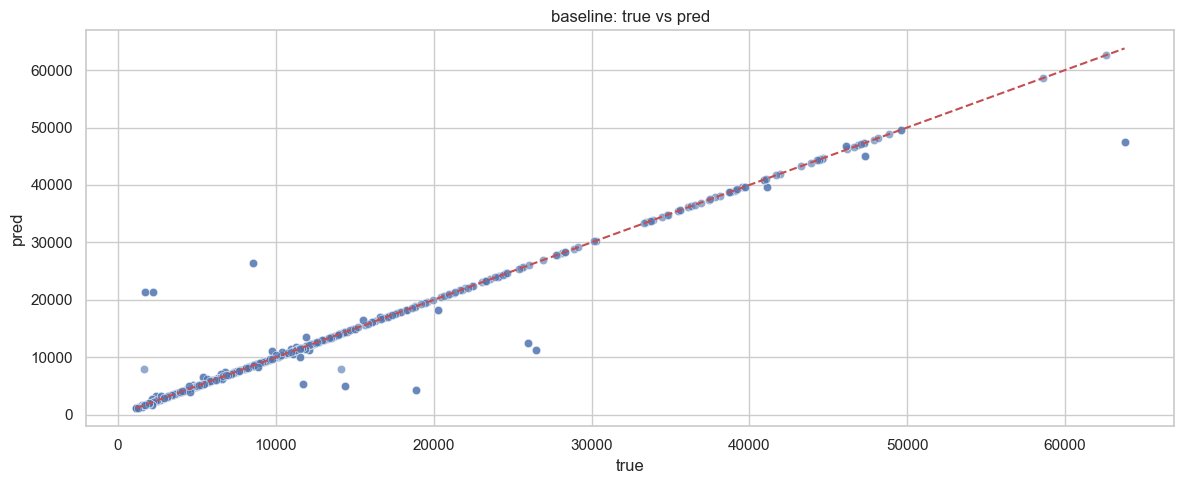

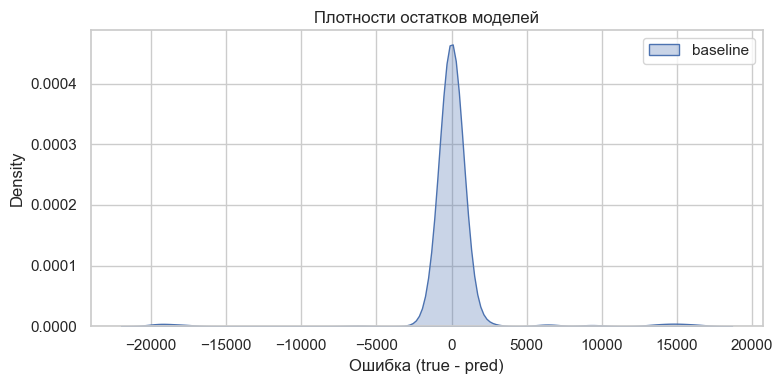

In [13]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    reg_features, reg_target, test_size=0.2, random_state=RANDOM_STATE
)

reg_baseline = Pipeline(
    steps=[
        ("preprocess", reg_preprocessor),
        (
            "model",
            DecisionTreeRegressor(
                max_depth=None,
                random_state=RANDOM_STATE,
            ),
        ),
    ]
)

reg_baseline.fit(X_train_r, y_train_r)
base_pred_reg = reg_baseline.predict(X_test_r)

results_reg = {}
results_reg["baseline_tree"] = regression_report_dict(y_test_r, base_pred_reg)

plot_predictions(y_test_r, {"baseline": base_pred_reg})
plot_residuals(y_test_r, {"baseline": base_pred_reg})

Тюнинг дерева (регрессия)\
GridSearchCV по глубине, min_samples_leaf/split

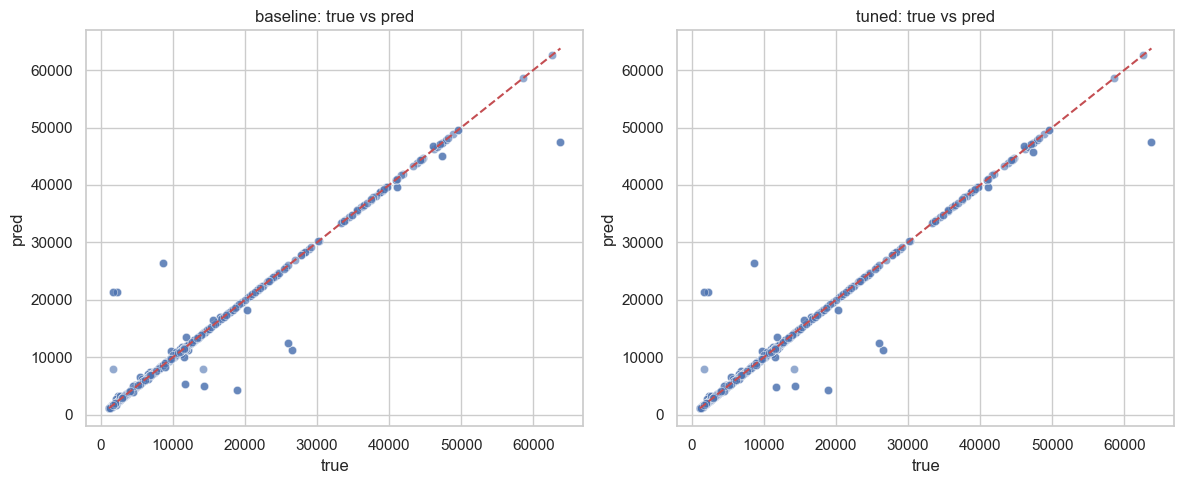

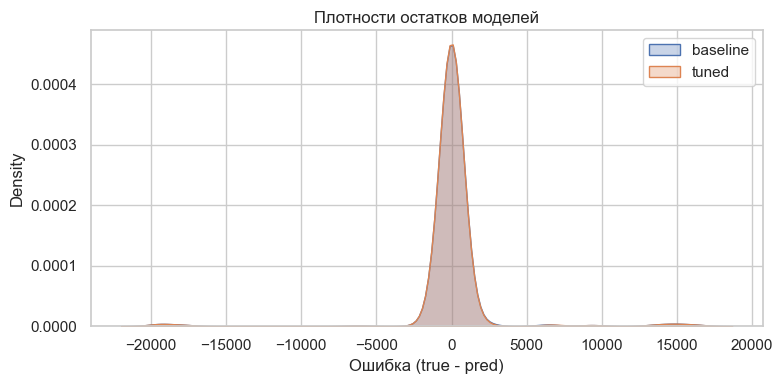

In [14]:
param_grid_reg = {
    "model__max_depth": [4, 8, 14, None],
    "model__min_samples_leaf": [1, 5, 15],
    "model__min_samples_split": [2, 10, 20],
    "model__criterion": ["squared_error", "friedman_mse"],
}

reg_search = GridSearchCV(
    estimator=reg_baseline,
    param_grid=param_grid_reg,
    scoring="neg_mean_absolute_error",
    cv=5,
    n_jobs=-1,
)
reg_search.fit(X_train_r, y_train_r)

best_tree_reg = reg_search.best_estimator_
best_pred_reg = best_tree_reg.predict(X_test_r)

results_reg["tuned_tree"] = regression_report_dict(y_test_r, best_pred_reg)

plot_predictions(y_test_r, {"baseline": base_pred_reg, "tuned": best_pred_reg})
plot_residuals(y_test_r, {"baseline": base_pred_reg, "tuned": best_pred_reg})

Важность признаков для лучшего дерева (регрессия)\
Показываем топ значимых признаков

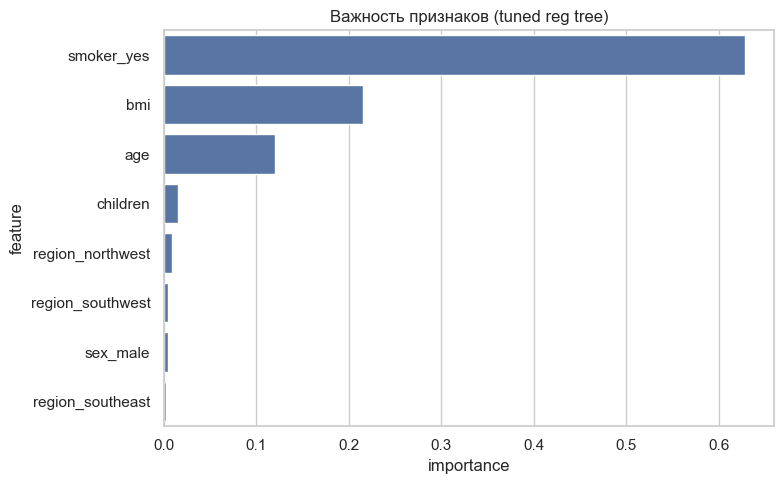

In [15]:
feature_names_reg = (
    reg_preprocessor.named_transformers_["num"].get_feature_names_out(num_cols).tolist()
    + reg_preprocessor.named_transformers_["cat"].named_steps["encoder"].get_feature_names_out(cat_cols).tolist()
)
plot_feature_importance(
    best_tree_reg.named_steps["model"].feature_importances_,
    feature_names_reg,
    "Важность признаков (tuned reg tree)",
)

Оценка кастомного дерева (регрессия) на компактной выборке\
Сжимаем выборку и сравниваем с sklearn

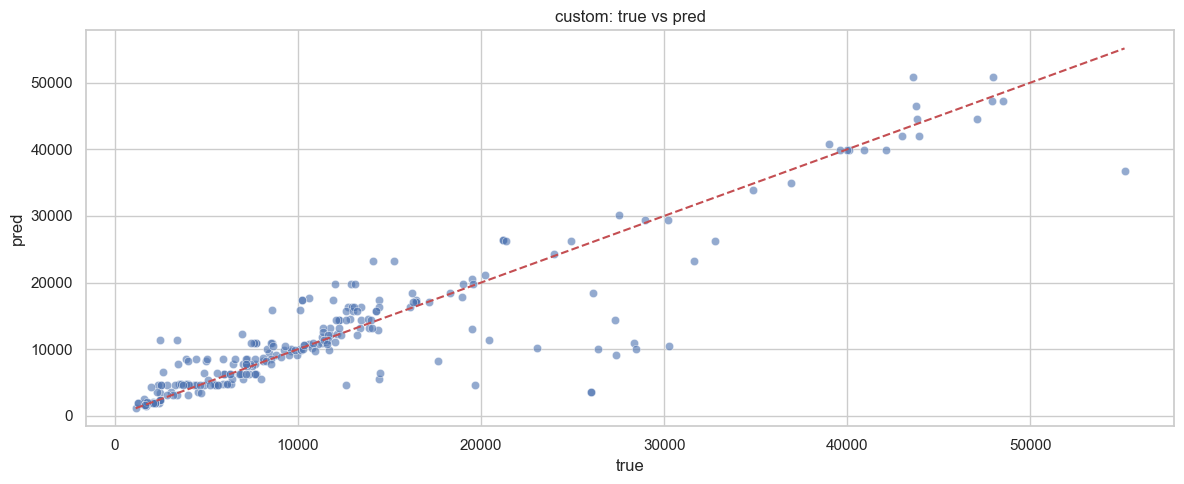

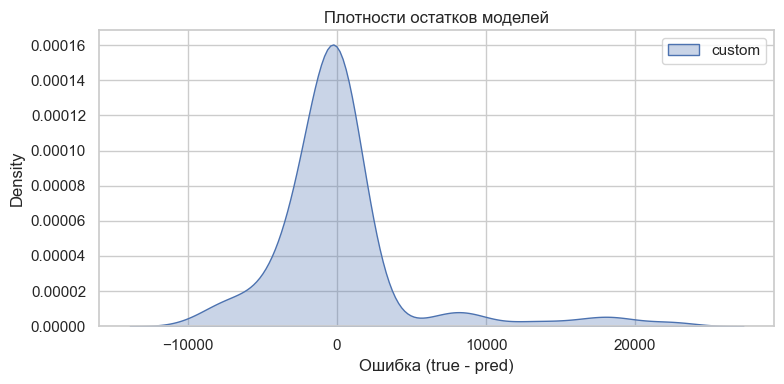


Метрики регрессии (деревья)
                     mae       rmse      r2
baseline_tree   588.7106  2787.6640  0.9494
tuned_tree      583.6016  2788.6276  0.9493
custom_tree    2553.0353  4769.1145  0.8142


In [16]:
X_reg_small, _, y_reg_small, _ = train_test_split(
    reg_features, reg_target, train_size=1200, random_state=RANDOM_STATE
)

X_train_rs, X_test_rs, y_train_rs, y_test_rs = train_test_split(
    X_reg_small, y_reg_small, test_size=0.2, random_state=RANDOM_STATE
)

custom_tree_reg = Pipeline(
    steps=[
        ("preprocess", reg_preprocessor),
        ("model", SimpleDecisionTreeRegressor(max_depth=8, min_samples_leaf=5)),
    ]
)

custom_tree_reg.fit(X_train_rs, y_train_rs)
custom_pred_reg = custom_tree_reg.predict(X_test_rs)

results_reg["custom_tree"] = regression_report_dict(y_test_rs, custom_pred_reg)

plot_predictions(y_test_rs, {"custom": custom_pred_reg})
plot_residuals(y_test_rs, {"custom": custom_pred_reg})

show_results_table(results_reg, "Метрики регрессии (деревья)")

## Выводы
Классификация: тюнингованное дерево заметно подняло полноту и ROC AUC (до примерно 0.93), но ценой снижения Accuracy. Базовая и кастомная версии обеспечивают более высокую точность при меньшей полноте. Если цель — обнаружить как можно больше положительных случаев, лучше тюнингованное дерево; при акценте на точность — базовый или кастомный вариант.

Регрессия: базовое и тюнингованное деревья дают близкие показатели (MAE около 584–589, R² около 0.949). Кастомная реализация значительно хуже, поэтому рекомендуется использовать реализованные в библиотеке деревья, тюнинг дает небольшое, но стабильное улучшение.